In [4]:
%matplotlib inline

import numpy as np
import os
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


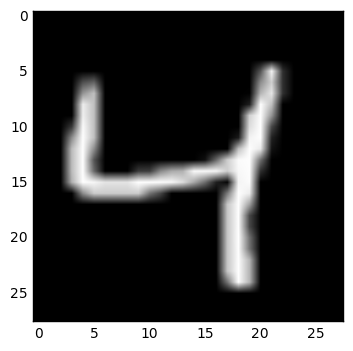

In [6]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [ ]:
# Create the model inputs
def model_inputs(image_width, image_height, image_channels, embedded_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    real_input_images = tf.placeholder(tf.float32, \
                                       shape=(None,image_width,\
                                              image_height,\
                                              image_channels))
    
    embedded_data = tf.placeholder(tf.float32, \
                           shape=(None,embedded_dim))
    
    learning_rate = tf.placeholder(tf.float32, \
                                  shape=None)

    target_input_images = tf.placeholder(tf.float32, \
                                        shape=(None,image_width,\
                                              image_height,\
                                              image_channels))
    return real_input_images, embedded_data, learning_rate, target_input_images

In [7]:
def leaky_relu(x, alpha=0.1, name='leaky_relu'):
            return tf.maximum(x, alpha * x, name=name)

In [ ]:
# encoding network
def encoder(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    #TODO Batch Normalization
    
    with tf.variable_scope('encoder', reuse=reuse):
        # Input layer is 28x28x1
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = leaky_relu(conv1)
        # 14x14x64
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = leaky_relu(bn2)
        # 7x7x128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = leaky_relu(bn3)
        #7x7x256
        
        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*256))
        
        # Dropout
        dropout = tf.nn.dropout(flat,0.8)
        
        # Logits
        logits = tf.layers.dense(dropout, 1,\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.sigmoid(logits)
        
        
        
    return out, logits

In [ ]:
# Generator
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1,0.5)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2,0.5)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3,0.5)
        # 28x28x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out

In [ ]:
# Descriminator
def descriminator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1,0.5)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2,0.5)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3,0.5)
        # 28x28x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out

In [ ]:
# Classifier
def classifier(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512,\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        x1 = tf.nn.dropout(x1,0.5)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2,0.5)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3,0.5)
        # 28x28x256 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',\
                                kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out

In [ ]:
def model_loss(input_real, input_z, out_channel_dim, target_real):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    # generator for fake images
    g_logits = generator(input_z, out_channel_dim, is_train=True, reuse=True)
    
    # encoder for real and faked images
    e_model_real, e_logits_real = encoder(input_real, reuse=False)
    e_model_fake, e_logits_fake = encoder(g_logits, reuse=True)
    
    # descriminator for real and faked images
    d_model_real, d_logits_real = discriminator(e_model_encoder_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(e_model_encoder_fake, reuse=True)
    
    # classifier
    c_model_real, c_logits_real = classifier(e_model_encoder_real, reuse=False)
    c_model_fake, c_logits_fake = classifier(e_model_encoder_fake, reuse=True)
    
    # autoencoder
    a_model_real, a_logits_real = generator(e_logits_real, reuse=True)
    
    # descriminator loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, \
                                                labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, \
                                                labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # generator loss
    # fake comparing descriminator with '1'
    g_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    # real comparing input_real with autoencoder image
    g_loss_real = tf.nn.cross_entropy_with_logits(labels=target_real, logits=a_logits_real)
    g_cost_real = tf.reduce_mean(g_loss_real)
    
    g_loss = g_loss_fake + g_loss_real
    
    #TODO Classifier loss
    
    return d_loss, g_loss_fake, g_loss_real

In [ ]:
def model_opt(d_loss, g_loss, e_loss, c_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    e_vars = [var for var in t_vars if var.name.startswith('encoder')]
    c_vars = [var for var in t_vars if var.name.startswith('classifier')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        e_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(e_loss, var_list=d_vars)
        c_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(c_loss, var_list=g_vars)

    return d_train_opt, g_train_opt, e_train_opt, c_train_opt

In [ ]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    clear_output()
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
#     example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])
    example_z = np.random.normal(0.,1.,size=[n_images, z_dim])
    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()